# Exploring Over 5 Years of NordPool Data

### Introduction

This is an analysis of hourly electricity spot price data in the Nordics (excl. Iceland) and the Baltics. The data is freely available on https://www.nordpoolgroup.com/historical-market-data/.

NordPool was established in 1993 by the Norwegian TSO Statnett after the Norwegian parliament decided to deregulate the electricity market in 1991. This was the first deregulated market in the world, and NordPool expanded in 1996 to also cover the Swedish market. In 1998 Finland joined, and in 2000 Denmark also became part of the join electricity trade market. 


This analysis is created by Rasmus Vester Thøgersen and made available on GitHub through the MIT License. Link to the GitHub-repository: https://github.com/rasmusthog/nordpool-data-analysis

# 1. Importing data and EDA

Let's start importing the data and doing some exploratory data analysis (EDA). 

The data has been cleaned using a seperate script called "import_data.py", available at the GitHub repository. This imports the hourly elspot price files in .CSV-format (manually exported from .XLS due to some import errors), cleans the data and concatenates the files into a single .CSV-file containing data from 2013-2018.

count    48863.000000
mean        30.194939
std          9.662997
min          1.140000
25%         24.740000
50%         29.570000
75%         35.370000
max        199.970000
Name: SYS, dtype: float64


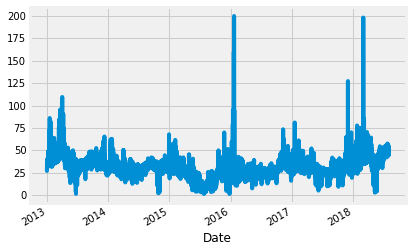

In [8]:
# importing modules
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# importing full dataset

elspot_df = pd.read_csv("datasets/total-elspot-prices_2013-2018.csv", delimiter=",", header=0, index_col="Date", parse_dates=True)

# Look at the description and visual plot of the system price.
print(elspot_df["SYS"].describe())
elspot_df["SYS"].plot()


We're working with a large dataset of 48863 entries, one for each hour since 1st January 2013. The system price mean is 30.19€ with a standard deviation of 9.66€. The system price has been as high as 199.97€, and as low as 1.14€.

The maximum values are shown as two very large peaks, and there is also one slightly smaller. These two large peaks occured on 21st January 2016 (at 08:00 and 18:00) and 1st March 2018 (at 08:00). These peak correspond to about 7 times the mean elspot price. After having contacted NordPool, they confirmed that this data is real and is due to high congestion in the system, due to limited transmission capacity, planned downtime on transmission lines, large consumption peaks or downtime on a large production facility. 

As these peaks are real data, I will not do anything to remove them (at least not at this point).

### Investigating how daylight saving time is handled

There are two dates a year where we change to and from daylight saving time. We enter daylight saving time the last Sunday of October, and leave it the last Sunday in March. Let's find out how this is handled in this dataset.

In [91]:
# Let's find the dates for the last Sunday in March and October each year.

dates_df = elspot_df[["SYS"]]
dates_df = dates_df.resample("D").mean()
dates_df["Day"] = dates_df.index.weekday

years = [2013, 2014, 2015, 2016, 2017, 2018]
exit_dls = []

# Get dates for enter and exit daylight saving time 
for year in years:
    # Get exit daylight saving time dates
    date_str_start = "%d-03-25" % year
    date_str_end = "%d-03-31" % year
    
    df_subset_exit = dates_df.loc[date_str_start:date_str_end]
    
    exit_dls.append(df_subset_exit["Day"].idxmax().day)

    
enter_dls = []
    
for year in years:
    # Repeat for enter daylight saving time
    date_str_start = "%d-10-25" % year
    date_str_end = "%d-10-31" % year
    
    df_subset_enter = dates_df.loc[date_str_start:date_str_end]
    
    #enter_dls.append(df_subset_enter["Day"].idxmax().day)

# 2. Investigating differences _within_ countries

Each country may have several bidding areas, or price regions. These are decided by the local transmission system operator (TSO), and are subject to change over time. Today, the following bidding areas exist: 

- Norway: NO1, NO2, NO3, NO4, NO5
- Sweden: SE1, SE2, SE3, SE4
- Denmark: DK1, DK2
- Finland: FI
- Latvia: LV
- Lithuania: LT
- Estonia: EE

<img src="img/bidding-areas.png" width="400px">


The reason for the division is due to the limited transmission capacity between different geographical areas, as flow may be congested and price differences may help curb demand or up supply in congested areas. 

Let's investigate the evolution of the prices in the different countries, and compare to the mean overall system price (marked with a red horizontal line) for the past 4,5 years. In order to smoothe out the large fluctuations we may have due to the high resolution of the data (hourly), the data has been averaged using a rolling window mean of 60 days. This makes it easier to distinguish the general patterns of how the price moves.

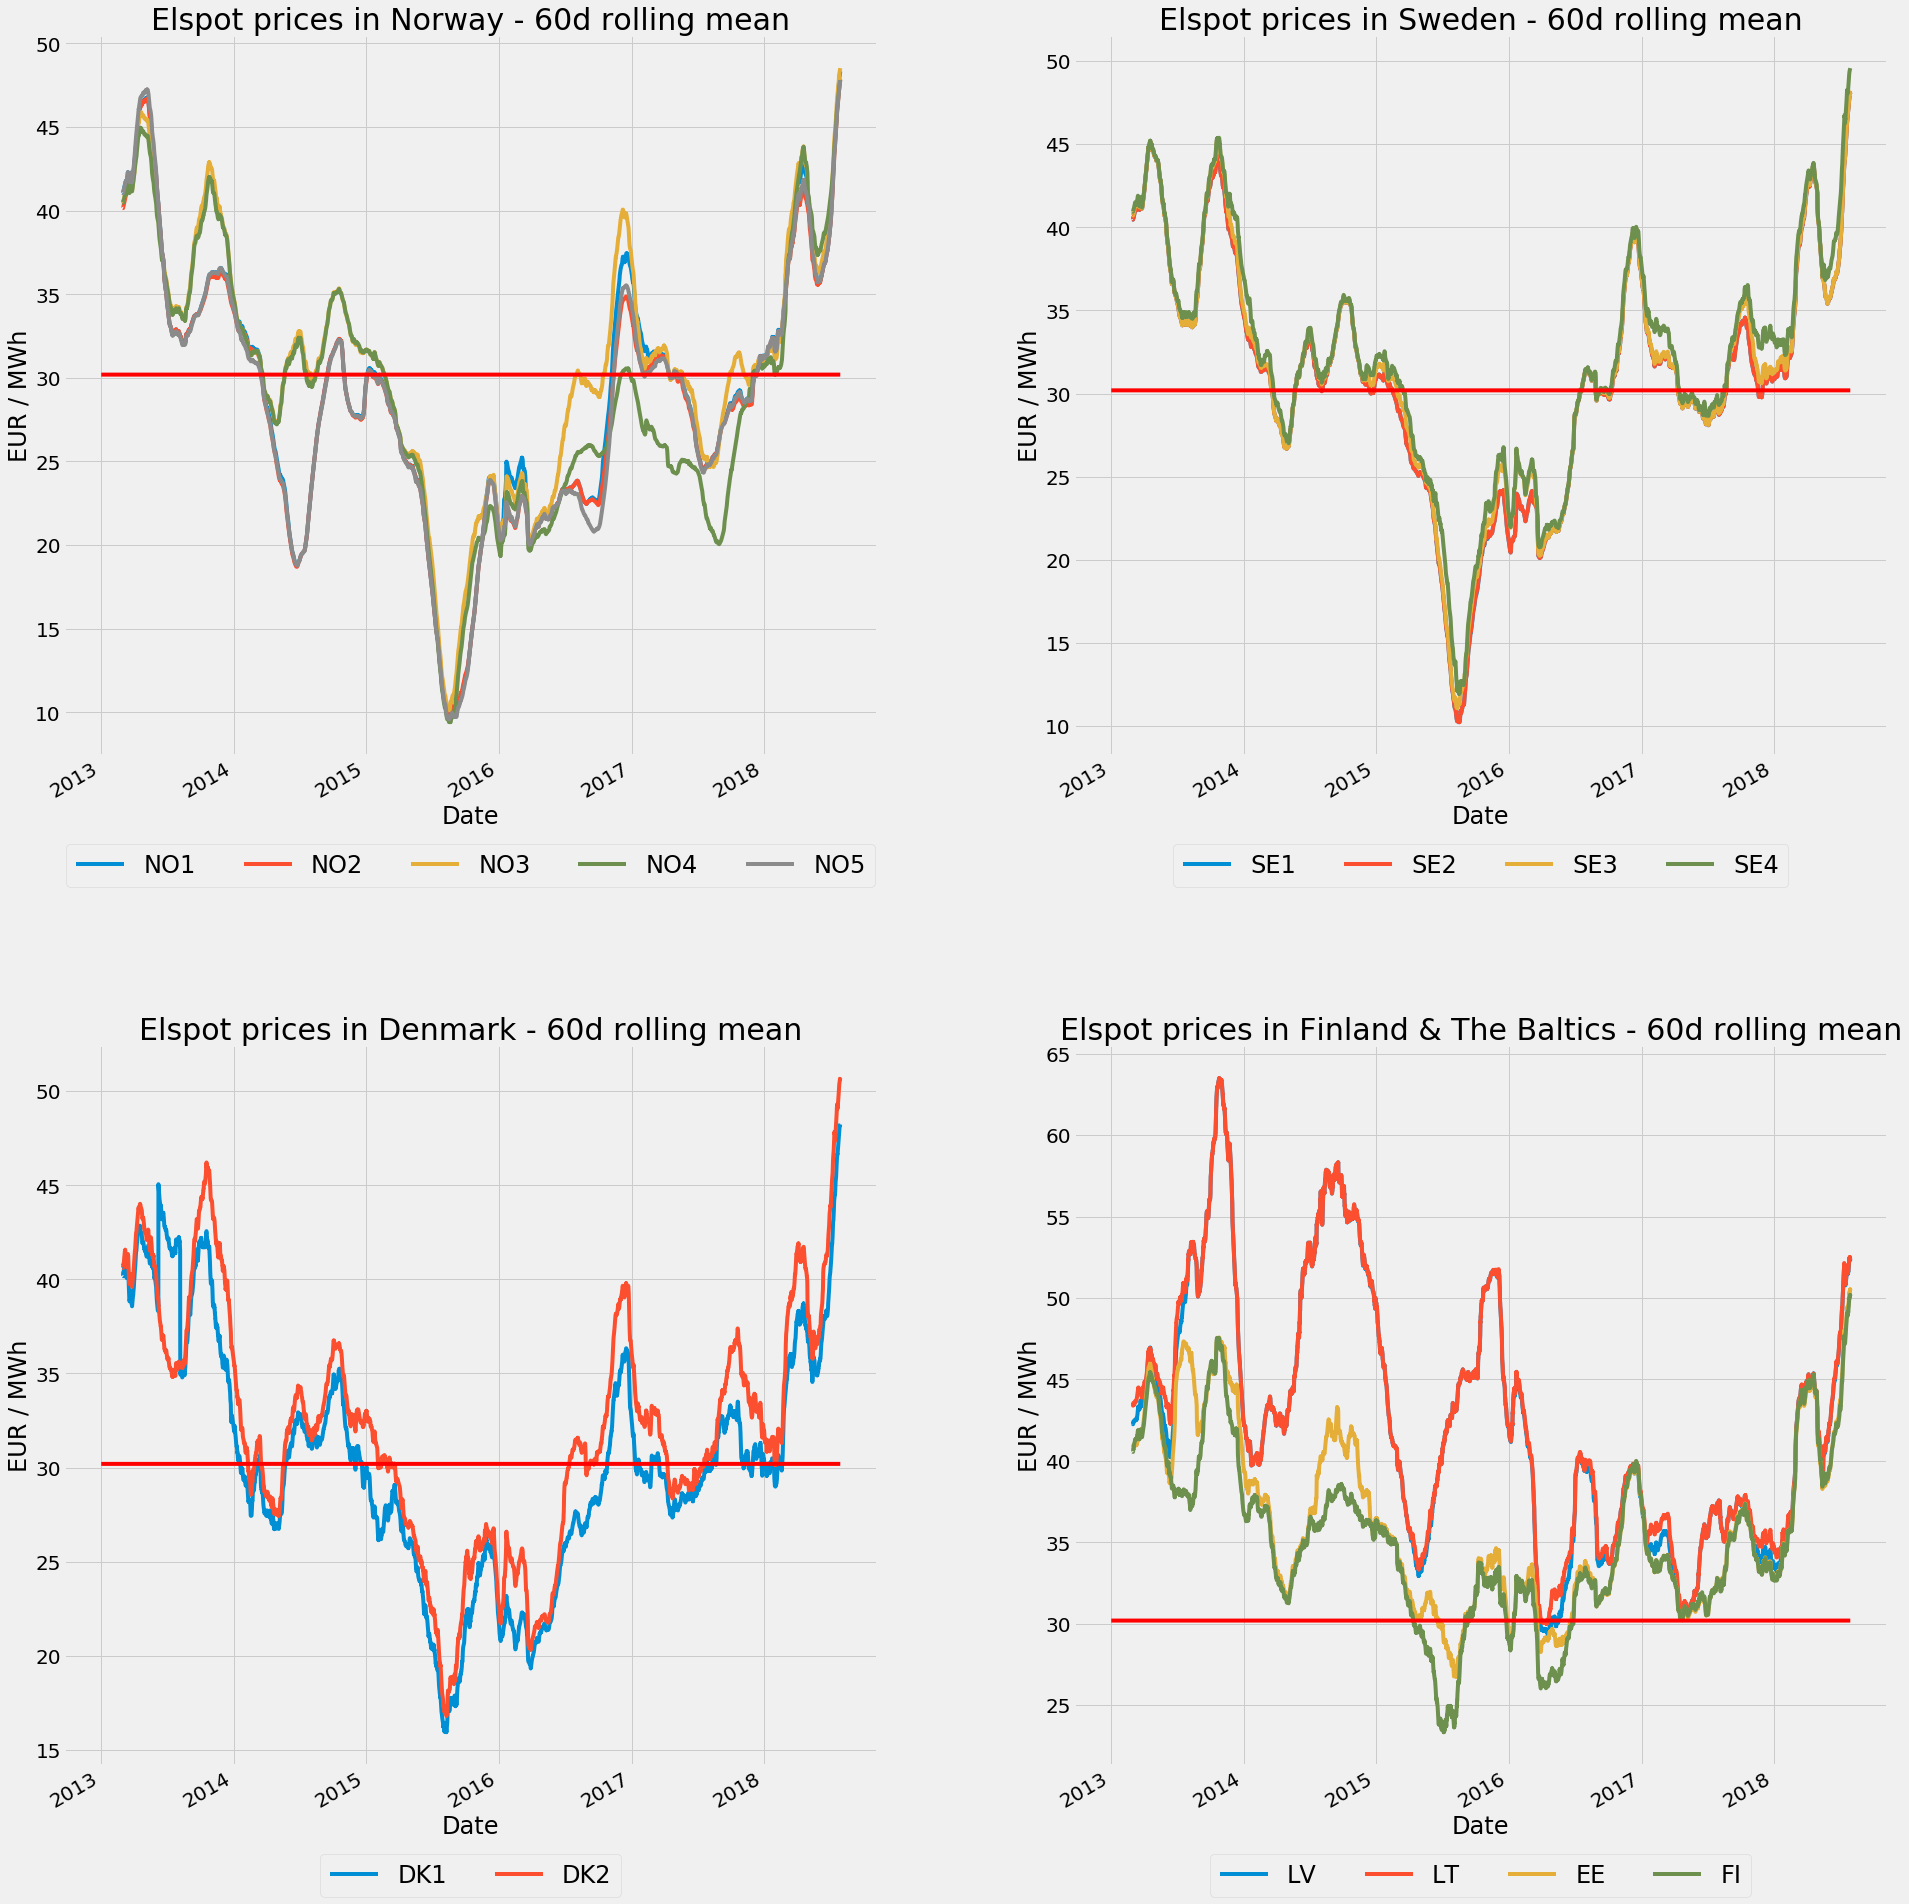

In [34]:
# Create lists of zones specific to each country. Baltics and Finland is grouped together as
# each country as one zone only


plt.style.use("fivethirtyeight")
norway = ["NO1", "NO2", "NO3", "NO4", "NO5"]
sweden = ["SE1", "SE2", "SE3", "SE4"]
denmark = ["DK1", "DK2"]
baltics_fin = ["LV", "LT", "EE", "FI"]


# Make 60 day moving window average of prices to smooth out the curves. 
# Requiring the mean to be made up of 2 months of observations.
elspot_df_smoothed = elspot_df.rolling("60d", min_periods=1439).mean()

# Plot Norway
plt.subplot(2,2,1)

for zone in norway:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 60]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Norway - 60d rolling mean", fontsize=30)

# Plot Sweden
plt.subplot(2,2,2)

for zone in sweden:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Sweden - 60d rolling mean", fontsize=30)

# Plot Denmark
plt.subplot(2,2,3)

for zone in denmark:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Denmark - 60d rolling mean", fontsize=30)

# Plot Baltics & Finland 
plt.subplot(2,2,4)

for zone in baltics_fin:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Finland & The Baltics - 60d rolling mean", fontsize=30)


plt.tight_layout(pad=10)

There are of some interesting observations from this. First of all, there are clear price differences within each country, except for **Sweden** where the four bidding areas have approximately the same price for most of the period we're looking at. In **Norway**, there's a large discrepancy between the prices, except in certain periods where the price is very similar. In **Denmark**, the eastern bidding area consistently lies above the western, and in the **Baltics**, Latvia and Lithuenia has historically experienced much larger prices than in Estonia, however, this seems to have changed the past year. **Finland** has been at a level below the Baltics, but they are all generally well above the mean system price.

Looking at the average prices in the different countries (treating The Baltics and Finland as one area still), we see that the prices in Norway generally are below the others, though for a large amount of the time folowing the price in Sweden and Denmark quite well.

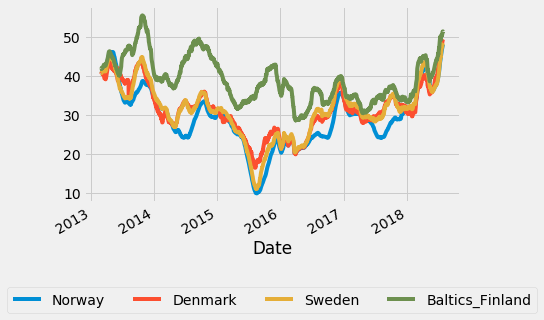

In [33]:
elspot_df["Norway"] = elspot_df[norway].mean(axis=1)
elspot_df["Sweden"] = elspot_df[sweden].mean(axis=1)
elspot_df["Denmark"] = elspot_df[denmark].mean(axis=1)
elspot_df["Baltics_Finland"] = elspot_df[baltics_fin].mean(axis=1)

# Make 60 day moving window average of prices to smooth out the curves. 
# Requiring the mean to be made up of 2 months of observations.
elspot_df_smoothed = elspot_df.rolling("60d", min_periods=1439).mean()

ax = elspot_df_smoothed[["Norway", "Denmark", "Sweden", "Baltics_Finland"]].plot()
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=5, fontsize=14)



# 4. Time of day

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

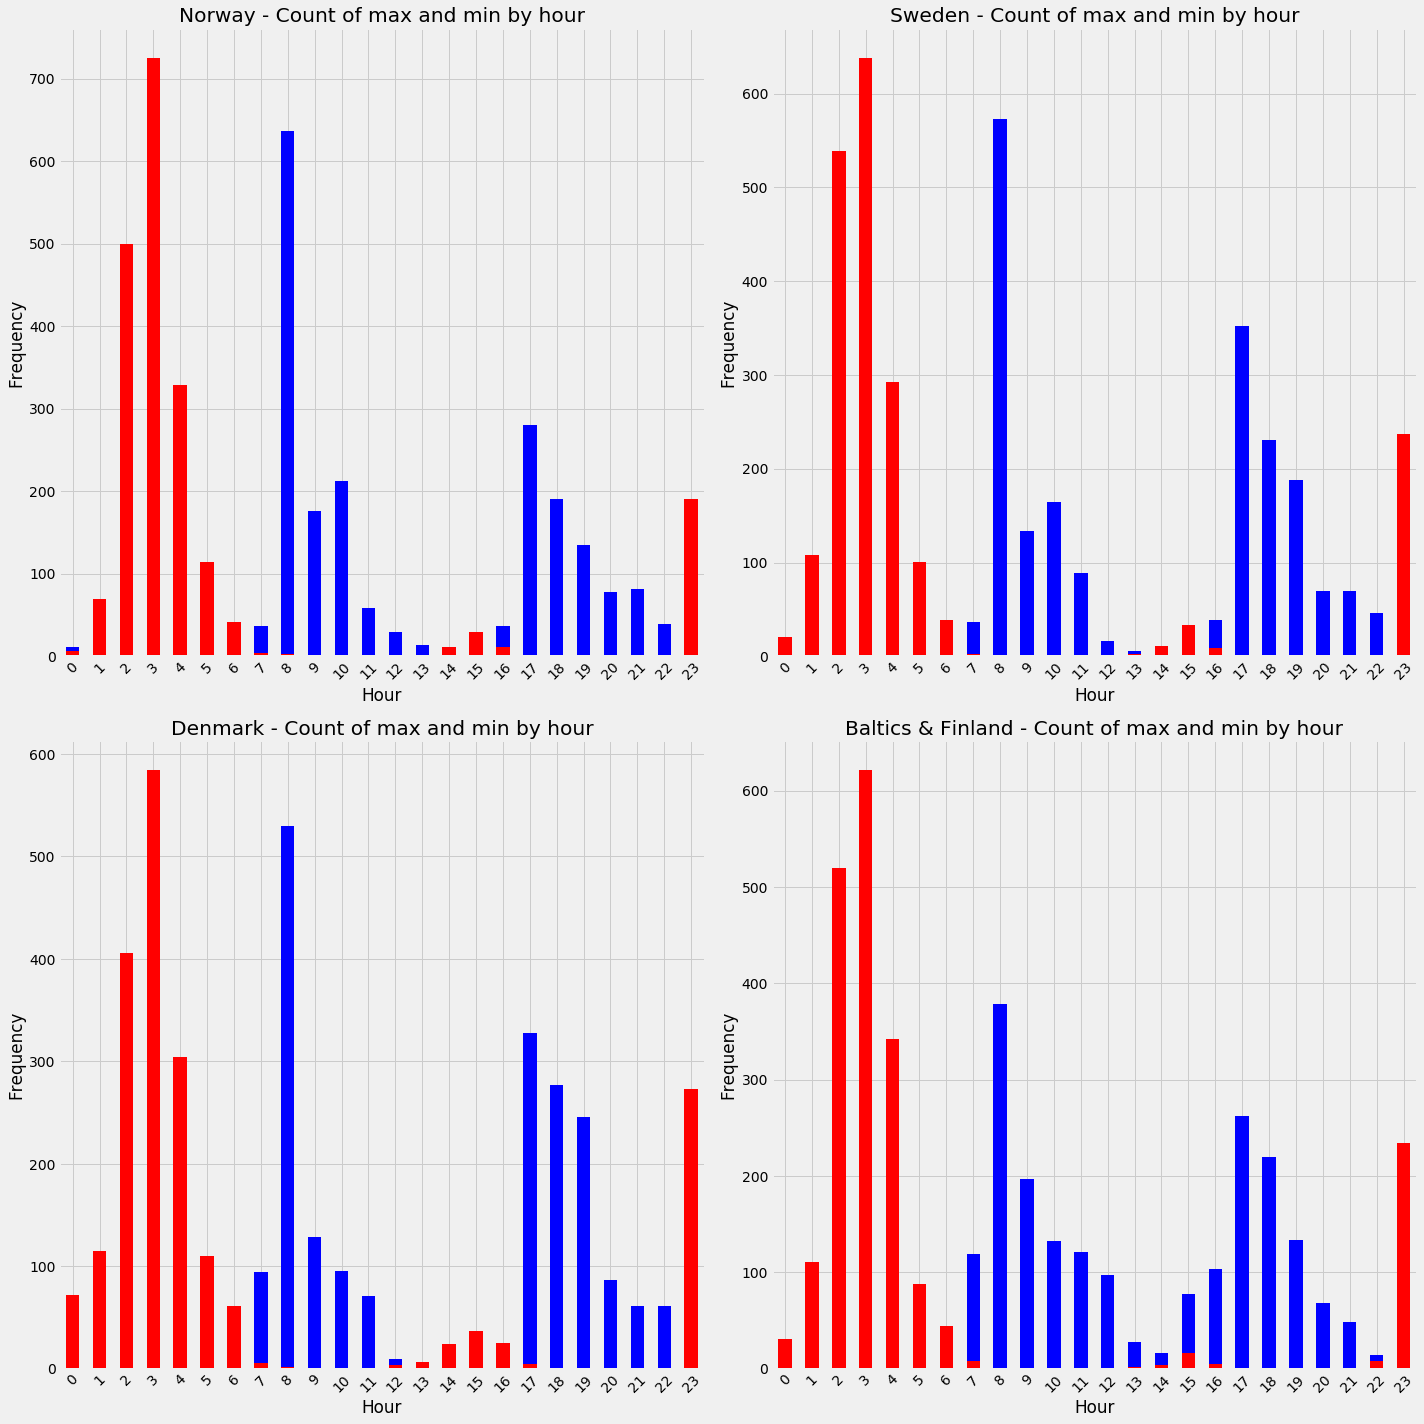

In [19]:
# Resample data for Norway per day with .max() and .min() values extracted with time of extrema as index.

elspot_df_norway = elspot_df[["Norway"]]
elspot_df_norway_max = elspot_df_norway.loc[elspot_df_norway.groupby(pd.Grouper(freq="1d")).idxmax().iloc[:, 0]]
elspot_df_norway_max["Hour"] = elspot_df_norway_max.index.hour

elspot_df_norway_min = elspot_df_norway.loc[elspot_df_norway.groupby(pd.Grouper(freq="1d")).idxmin().iloc[:, 0]]
elspot_df_norway_min["Hour"] = elspot_df_norway_min.index.hour

# Resample data for Sweden per day with .max() and .min() values extracted with time of extrema as index.

elspot_df_sweden = elspot_df[["Sweden"]]
elspot_df_sweden_max = elspot_df_sweden.loc[elspot_df_sweden.groupby(pd.Grouper(freq="1d")).idxmax().iloc[:, 0]]
elspot_df_sweden_max["Hour"] = elspot_df_sweden_max.index.hour

elspot_df_sweden_min = elspot_df_sweden.loc[elspot_df_sweden.groupby(pd.Grouper(freq="1d")).idxmin().iloc[:, 0]]
elspot_df_sweden_min["Hour"] = elspot_df_sweden_min.index.hour

# Resample data for Denmark per day with .max() and .min() values extracted with time of extrema as index.

elspot_df_denmark = elspot_df[["Denmark"]]
elspot_df_denmark_max = elspot_df_denmark.loc[elspot_df_denmark.groupby(pd.Grouper(freq="1d")).idxmax().iloc[:, 0]]
elspot_df_denmark_max["Hour"] = elspot_df_denmark_max.index.hour

elspot_df_denmark_min = elspot_df_denmark.loc[elspot_df_denmark.groupby(pd.Grouper(freq="1d")).idxmin().iloc[:, 0]]
elspot_df_denmark_min["Hour"] = elspot_df_denmark_min.index.hour

# Resample data for Denmark per day with .max() and .min() values extracted with time of extrema as index.

elspot_df_baltics_finland = elspot_df[["Baltics_Finland"]]
elspot_df_baltics_finland_max = elspot_df_baltics_finland.loc[elspot_df_baltics_finland.groupby(pd.Grouper(freq="1d")).idxmax().iloc[:, 0]]
elspot_df_baltics_finland_max["Hour"] = elspot_df_baltics_finland_max.index.hour

elspot_df_baltics_finland_min = elspot_df_baltics_finland.loc[elspot_df_baltics_finland.groupby(pd.Grouper(freq="1d")).idxmin().iloc[:, 0]]
elspot_df_baltics_finland_min["Hour"] = elspot_df_baltics_finland_min.index.hour


# Plot counts of max and min occurences by time of day for Norway

hours = [x for x in range(0,24)]

plt.figure()

# Plot Norway
plt.subplot(2,2,1)

norway_max_min = pd.DataFrame(hours)

norway_max_min["max"] = elspot_df_norway_max.groupby("Hour").count()
norway_max_min["min"] = elspot_df_norway_min.groupby("Hour").count()
norway_max_min = norway_max_min.fillna(0)
norway_max_min = norway_max_min.drop(0, axis=1)

ax1 = norway_max_min["max"].plot(kind="bar", color="b", figsize=(20,20))
norway_max_min["min"].plot(kind="bar", color="r", ax=ax1)
ax1.set_title("Norway - Count of max and min by hour")
ax1.set_xlabel("Hour")
plt.xticks(rotation=45)
ax1.set_ylabel("Frequency")

# Plot Sweden
plt.subplot(2,2,2)

sweden_max_min = pd.DataFrame(hours)

sweden_max_min["max"] = elspot_df_sweden_max.groupby("Hour").count()
sweden_max_min["min"] = elspot_df_sweden_min.groupby("Hour").count()
sweden_max_min = sweden_max_min.fillna(0)
sweden_max_min = sweden_max_min.drop(0, axis=1)

ax2 = sweden_max_min["max"].plot(kind="bar", color="b", figsize=(20,20))
sweden_max_min["min"].plot(kind="bar", color="r", ax=ax2)
ax2.set_title("Sweden - Count of max and min by hour")
ax2.set_xlabel("Hour")
plt.xticks(rotation=45)
ax2.set_ylabel("Frequency")


# Plot Denmark
plt.subplot(2,2,3)

denmark_max_min = pd.DataFrame(hours)

denmark_max_min["max"] = elspot_df_denmark_max.groupby("Hour").count()
denmark_max_min["min"] = elspot_df_denmark_min.groupby("Hour").count()
denmark_max_min = denmark_max_min.fillna(0)
denmark_max_min = denmark_max_min.drop(0, axis=1)

ax3 = denmark_max_min["max"].plot(kind="bar", color="b", figsize=(20,20))
denmark_max_min["min"].plot(kind="bar", color="r", ax=ax3)
ax3.set_title("Denmark - Count of max and min by hour")
ax3.set_xlabel("Hour")
plt.xticks(rotation=45)
ax3.set_ylabel("Frequency")

# Plot Baltics & Finland
plt.subplot(2,2,4)

baltics_finland_max_min = pd.DataFrame(hours)

baltics_finland_max_min["max"] = elspot_df_baltics_finland_max.groupby("Hour").count()
baltics_finland_max_min["min"] = elspot_df_baltics_finland_min.groupby("Hour").count()
baltics_finland_max_min = baltics_finland_max_min.fillna(0)
baltics_finland_max_min = baltics_finland_max_min.drop(0, axis=1)

ax4 = baltics_finland_max_min["max"].plot(kind="bar", color="b", figsize=(20,20))
baltics_finland_max_min["min"].plot(kind="bar", color="r", ax=ax4)
ax4.set_title("Baltics & Finland - Count of max and min by hour")
ax4.set_xlabel("Hour")
plt.xticks(rotation=45)
ax4.set_ylabel("Frequency")


# Tighten layout
plt.tight_layout()


Looking at the different profiles for when the maxima and minima occur for the (country mean) spot price, there doesn't seem to be a big difference between the different regions. The minima usually occurs during night starting at 23:00 and lasting until 06:00, with a clear peak at 02:00-04:00 for every country. Every country also has a strange peak at 23:00 before going down at 00:00, which should be investaged further - could be an artefact, but could also be due to variations over time or variations due to seasons. 

Next, let's look at the difference between the maximum and minimum price in the different countries.

            Norway       Sweden      Denmark  Baltics_Finland
count  2036.000000  2036.000000  2036.000000      2036.000000
mean      7.718252    14.326886    21.393867        28.008070
std       8.173563    12.897259    25.561128        21.186927
min       0.656000     1.060000     1.060000         1.360000
25%       3.857000     6.980000    11.210000        15.613750
50%       5.505000    11.370000    17.875000        23.845000
75%       8.637500    17.647500    27.287500        34.453750
max     135.920000   216.190000   985.360000       216.190000


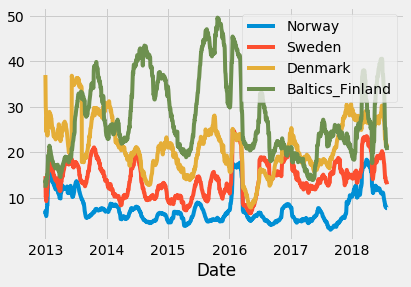

In [12]:
elspot_df_norway_diff = elspot_df_norway_max.resample("1d").mean() - elspot_df_norway_min.resample("1d").mean()
elspot_df_norway_diff = elspot_df_norway_diff.drop("Hour", axis=1)

elspot_df_sweden_diff = elspot_df_sweden_max.resample("1d").mean() - elspot_df_sweden_min.resample("1d").mean()
elspot_df_sweden_diff = elspot_df_sweden_diff.drop("Hour", axis=1)

elspot_df_denmark_diff = elspot_df_denmark_max.resample("1d").mean() - elspot_df_denmark_min.resample("1d").mean()
elspot_df_denmark_diff = elspot_df_denmark_diff.drop("Hour", axis=1)

elspot_df_baltics_finland_diff = elspot_df_baltics_finland_max.resample("1d").mean() - elspot_df_baltics_finland_min.resample("1d").mean()
elspot_df_baltics_finland_diff = elspot_df_baltics_finland_diff.drop("Hour", axis=1)

elspot_df_diff = pd.concat([elspot_df_norway_diff, elspot_df_sweden_diff, elspot_df_denmark_diff, elspot_df_baltics_finland_diff], axis=1)

print(elspot_df_diff.describe())

elspot_df_diff_smoothed = elspot_df_diff.rolling("60d").mean()

elspot_df_diff_smoothed.plot()


As can be seen, the difference is much less in Norway than in the other countries, with Sweden having the second lowest difference. This could very well be due to pumped hydro storage, which allows the producers to use the electricity generated (or purchase cheap power) to pump water back into reservoirs.

What about the peaks of minimum price that happens at 23:00? Is this real, or is there something wrong with the data / handling of data?

# 5. Seasonal variations

Let's look at seasonal variations, and how the prices change from months to month and quarter to quarter.

In [13]:
# Extract years in different dataframes
elspot_df_2014 = elspot_df.loc["2014"]
elspot_df_2015 = elspot_df.loc["2015"]
elspot_df_2016 = elspot_df.loc["2016"]
elspot_df_2017 = elspot_df.loc["2017"]
elspot_df_2018 = elspot_df.loc["2018"]

# 

#print(elspot_df[["Molde", "Trondheim"]].head(48))


# look at difference between max and min in different seasons

